In [110]:
import pandas as pd
import numpy as np
import gzip
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# from ann_visualizer.visualize import ann_viz    

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense
from keras.optimizers import Adam

# Neural Network based Intrusion Detection System

## Importing the dataset


In [111]:
df = pd.read_csv('kddcup.data_10_percent.gz', header=None)
cols = pd.read_csv('kddcup.names',header=None)

df.tail()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.
494020,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.


etiquetas para la deteccion de intrusos
- "back": Indica un intento de acceso no autorizado a un sistema remoto para obtener acceso posterior.
- "buffer_overflow": Se refiere a un ataque en el que un programa o proceso intenta escribir más datos en un búfer de memoria de lo que puede contener, lo que puede resultar en la corrupción de la memoria y posiblemente permitir un acceso no autorizado al sistema.
- "ftp_write": Indica un intento de acceso no autorizado para escribir o transferir archivos a través del protocolo FTP.
- "guess_passwd": Se refiere a un intento de adivinar o descifrar contraseñas para obtener acceso no autorizado a un sistema.
- "imap": Indica un intento de acceso no autorizado al protocolo de correo IMAP.
- "ipsweep": Se refiere a un escaneo de direcciones IP con el objetivo de identificar hosts activos en una red.
- "land": Indica un ataque en el que se envían paquetes maliciosos con la dirección de origen y destino establecidas en la misma dirección IP, lo que puede causar una denegación de servicio.
- "loadmodule": Se refiere a un intento de carga y ejecución de un módulo o código malicioso en un sistema comprometido.
- "multihop": Indica un intento de saltar a través de múltiples sistemas comprometidos para ocultar la fuente de un ataque.
- "neptune": Indica un ataque de denegación de servicio (DoS) que tiene como objetivo abrumar un sistema o red con una gran cantidad de solicitudes y conexiones falsas.
- "nmap": Se refiere a la detección de puertos y servicios en una red utilizando la herramienta de escaneo de puertos Nmap.
- "perl": Indica un intento de ejecutar código Perl malicioso en un sistema comprometido.
- "phf": Se refiere a un ataque en el que se explota una vulnerabilidad en el servidor web para obtener acceso no autorizado a archivos protegidos.
- "pod": Indica un ataque de denegación de servicio (DoS) en el que se envían paquetes malformados o sobredimensionados para sobrecargar y bloquear un sistema.
- "portsweep": Se refiere a un escaneo de puertos en múltiples hosts con el objetivo de encontrar vulnerabilidades y servicios activos.
- "rootkit": Indica la presencia de un conjunto de herramientas y técnicas utilizadas para ocultar y mantener el acceso no autorizado a un sistema comprometido.
- "satan": Se refiere a un escaneo de red y detección de vulnerabilidades utilizando la herramienta de escaneo de seguridad satan.
- "smurf": Indica un ataque de denegación de servicio (DoS) en el que se envían paquetes de ping a una red de difusión, lo que resulta en una inundación de respuestas hacia la víctima.
- "spy": Indica actividades sos

In [112]:
with open('training_attack_types', 'r') as f:
    attack_types = f.read()
    print(attack_types)

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l




In [113]:
## Creating a dictionary of attack types
types = dict()
types['normal'] = 'normal'
for line in attack_types.split("\n"):
    if line:
        attack, description = line.split(" ", 1)
        types[attack] = description

print(types)

{'normal': 'normal', 'back': 'dos', 'buffer_overflow': 'u2r', 'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'ipsweep': 'probe', 'land': 'dos', 'loadmodule': 'u2r', 'multihop': 'r2l', 'neptune': 'dos', 'nmap': 'probe', 'perl': 'u2r', 'phf': 'r2l', 'pod': 'dos', 'portsweep': 'probe', 'rootkit': 'u2r', 'satan': 'probe', 'smurf': 'dos', 'spy': 'r2l', 'teardrop': 'dos', 'warezclient': 'r2l', 'warezmaster': 'r2l'}


Descripciones:

- 'normal': Indica tráfico normal, es decir, actividades legítimas y no maliciosas en la red.
- 'dos': Significa "Denial of Service" (DoS), que se refiere a un tipo de ataque en el que el objetivo es abrumar un sistema o una red con una gran cantidad de solicitudes o tráfico malicioso para que no pueda funcionar correctamente.
- 'u2r': Significa "User to Root" (Usuario a Root) y se refiere a ataques en los que un usuario no privilegiado intenta obtener acceso y privilegios de administrador (root) en un sistema comprometido.
- 'r2l': Significa "Remote to Local" (Remoto a Local) y se refiere a ataques en los que un usuario o entidad externa intenta obtener acceso no autorizado a un sistema o red.
- 'probe': Indica actividades de escaneo o sondeo de la red en busca de información sobre los sistemas y servicios disponibles, con el objetivo de encontrar vulnerabilidades o puntos de entrada para futuros ataques.

In [114]:
if cols[0][0] == 'back':
    cols = cols.drop(cols.index[0])
    cols.reset_index(drop=True, inplace=True)

cols = cols.dropna(axis=1)
cols.head()

,0
0,duration: continuous.
1,protocol_type: symbolic.
2,service: symbolic.
3,flag: symbolic.
4,src_bytes: continuous.


In [115]:
cols[[0,1]] = cols[0].str.split(':',expand = True)

cols.head()

,0,1
0,duration,continuous.
1,protocol_type,symbolic.
2,service,symbolic.
3,flag,symbolic.
4,src_bytes,continuous.


In [116]:
names = cols[0].tolist()
names.append('label')
df.columns = names

In [117]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [118]:
df['Attack Type'] = df['label'].apply(lambda x: types[x[:-1]])
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


## Exploratory Data Analysis

In [119]:
AT_count = df['Attack Type'].value_counts()
AT_count

Attack Type
dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: count, dtype: int64

In [120]:
AT_per = AT_count/len(df)*100
AT_per

Attack Type
dos       79.239142
normal    19.691066
probe      0.831341
r2l        0.227926
u2r        0.010526
Name: count, dtype: float64

In [121]:
lab_count = df.label.value_counts()
lab_count

label
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

In [122]:
lab_per = lab_count/len(df)*100
lab_per

label
smurf.              56.837665
neptune.            21.699685
normal.             19.691066
back.                0.445932
satan.               0.321646
ipsweep.             0.252418
portsweep.           0.210517
warezclient.         0.206469
teardrop.            0.198170
pod.                 0.053439
nmap.                0.046759
guess_passwd.        0.010728
buffer_overflow.     0.006073
land.                0.004251
warezmaster.         0.004048
imap.                0.002429
rootkit.             0.002024
loadmodule.          0.001822
ftp_write.           0.001619
multihop.            0.001417
phf.                 0.000810
perl.                0.000607
spy.                 0.000405
Name: count, dtype: float64

In [123]:
print("Shape :",df.shape)
print("Number of features :",len(df.columns))
print("missing values :",df.isnull().sum().sum())

Shape : (494021, 43)
Number of features : 43
missing values : 0


In [124]:
#cantidad total de valores nulos en el DataFrame
df.isna().sum().sum()

0

In [125]:
categorical = df.select_dtypes(include=['object']).columns
print("Categorical features :",categorical)
categorical = categorical.tolist()
print("Categorical features list:",categorical)
categorical.remove('label')
categorical.remove('Attack Type')
print("Extracted categorical features list:",categorical)

Categorical features : Index(['protocol_type', 'service', 'flag', 'label', 'Attack Type'], dtype='object')
Categorical features list: ['protocol_type', 'service', 'flag', 'label', 'Attack Type']
Extracted categorical features list: ['protocol_type', 'service', 'flag']


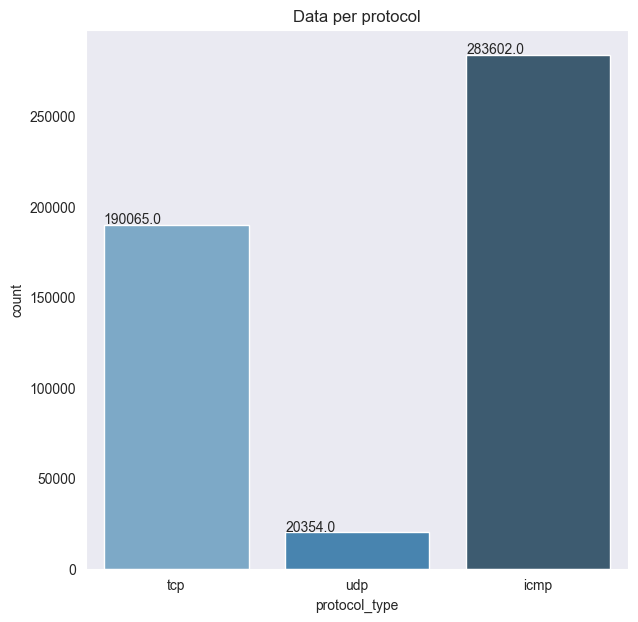

In [126]:
#visualizar la distribución de la columna 'protocol_type'
fig, ax = plt.subplots(figsize=(7, 7))
sns.countplot(x='protocol_type', data=df, ax=ax, palette='Blues_d')
sns.set_style("darkgrid")
ax.set_title("Data per protocol")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [127]:
df.protocol_type.value_counts()/len(df)*100

protocol_type
icmp    57.406871
tcp     38.473061
udp      4.120068
Name: count, dtype: float64

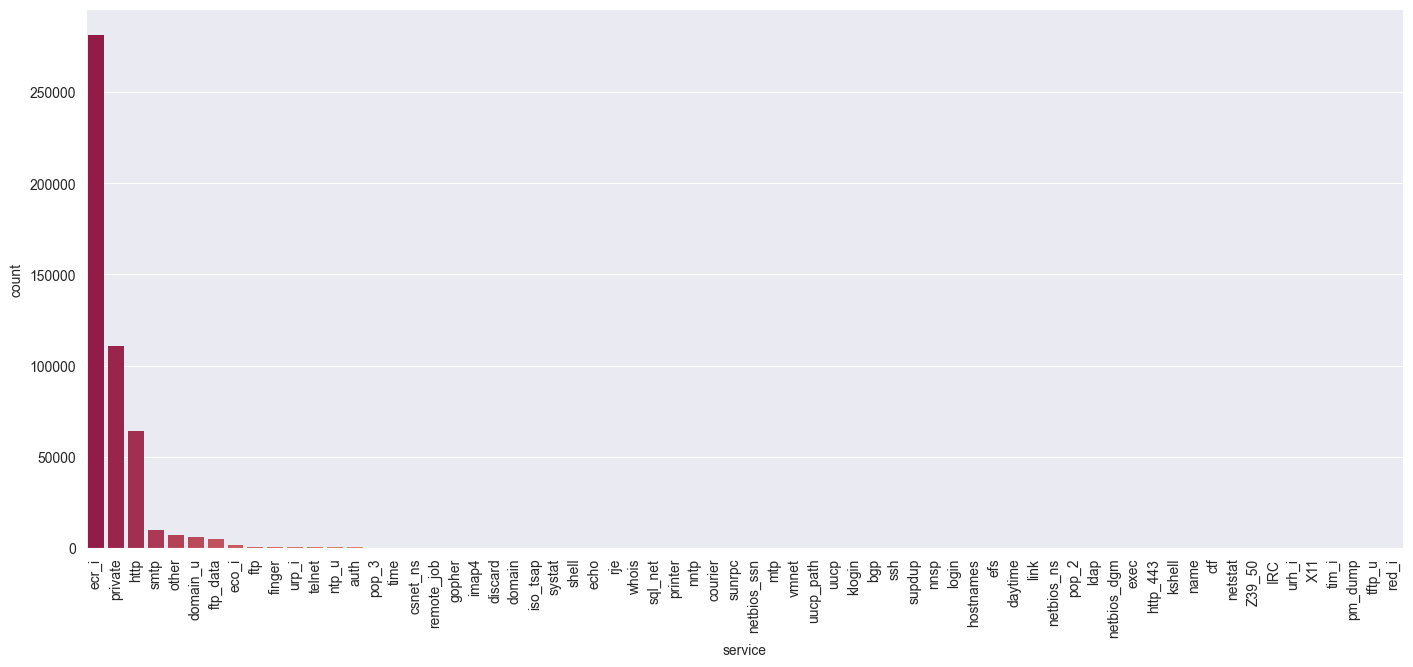

In [128]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.countplot(x='service', data=df, ax=ax, palette='Spectral', order=df['service'].value_counts().index,linewidth=0)
sns.set_style("dark")
plt.xticks(rotation=90)
plt.show()

In [129]:
df.service.value_counts()/len(df)*100

service
ecr_i      56.961141
private    22.447021
http       13.014224
smtp        1.968135
other       1.464917
             ...    
X11         0.002227
tim_i       0.001417
pm_dump     0.000202
tftp_u      0.000202
red_i       0.000202
Name: count, Length: 66, dtype: float64

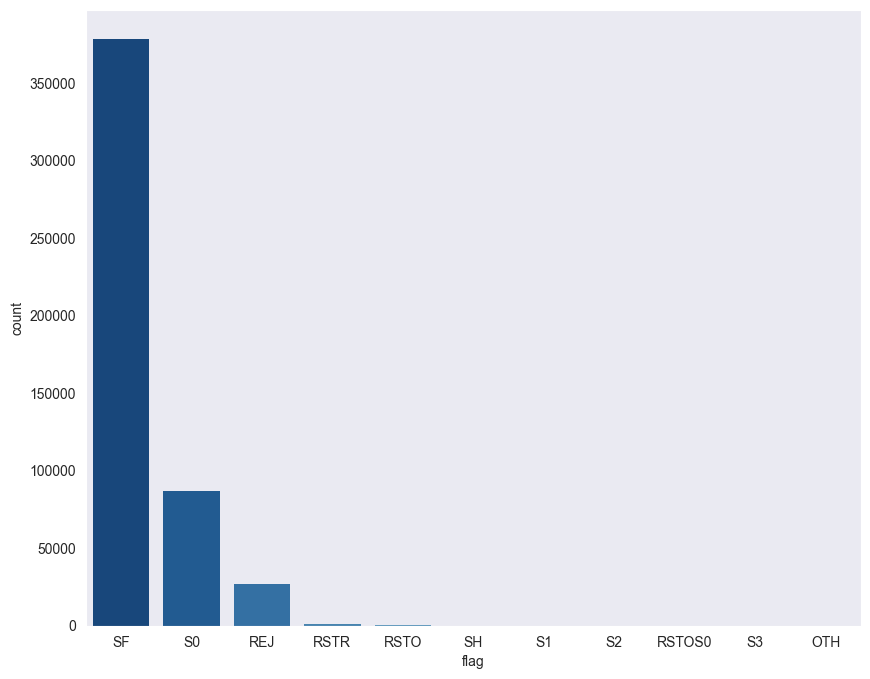

In [130]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x='flag', data=df, ax=ax, palette='Blues_r', order=df['flag'].value_counts().index,linewidth=0)
plt.show()

In [131]:
df.flag.value_counts()/len(df)*100

flag
SF        76.604031
S0        17.612004
REJ        5.440052
RSTR       0.182786
RSTO       0.117201
SH         0.021659
S1         0.011538
S2         0.004858
RSTOS0     0.002227
S3         0.002024
OTH        0.001619
Name: count, dtype: float64

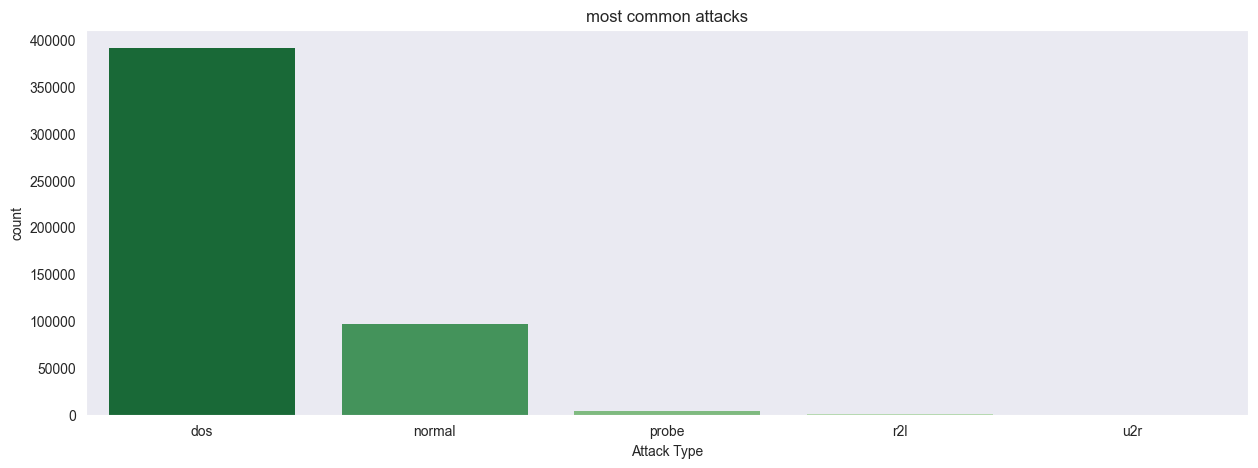

Top 3 the attack types are :  ['dos', 'normal', 'probe']


In [132]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='Attack Type', data=df, ax=ax, palette='Greens_r', order=df['Attack Type'].value_counts().index,linewidth=0)
ax.set_title("most common attacks")
plt.show()
print('Top 3 the attack types are : ',df['Attack Type'].value_counts().index[:3].tolist())

In [136]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [137]:
df['protocol_type'].value_counts()

protocol_type
icmp    283602
tcp     190065
udp      20354
Name: count, dtype: int64

In [138]:
df['service'].value_counts()

service
ecr_i      281400
private    110893
http        64293
smtp         9723
other        7237
            ...  
X11            11
tim_i           7
pm_dump         1
tftp_u          1
red_i           1
Name: count, Length: 66, dtype: int64

In [139]:
df['flag'].value_counts()

flag
SF        378440
S0         87007
REJ        26875
RSTR         903
RSTO         579
SH           107
S1            57
S2            24
RSTOS0        11
S3            10
OTH            8
Name: count, dtype: int64

## Label Encoding

In [140]:
Le = LabelEncoder()
df['protocol_type'] = Le.fit_transform(df['protocol_type'])
df['service'] = Le.fit_transform(df['service'])
df['flag'] = Le.fit_transform(df['flag'])

In [141]:
df['protocol_type'].value_counts()

protocol_type
0    283602
1    190065
2     20354
Name: count, dtype: int64

In [142]:
df = df.drop(['service'], axis=1)

In [143]:
df['flag'].value_counts()

flag
9     378440
5      87007
1      26875
4        903
2        579
10       107
6         57
7         24
3         11
8         10
0          8
Name: count, dtype: int64

In [144]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,Attack Type
0,0,1,9,181,5450,0,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,1,9,239,486,0,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,1,9,235,1337,0,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,1,9,219,1337,0,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,1,9,217,2032,0,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


In [145]:
#guardar dataset consolidado
df.to_csv('processed_kdd.csv', index=False)

## features

In [146]:
X = df.drop(['label', 'Attack Type'], axis=1)
y = df['Attack Type']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Train - Test Split

In [147]:
#tamaño del conjunto de prueba: 20%,  conjunto de entrenamiento: 80% 
#semilla para la generación de números aleatorios
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
y_train = np.array(y_train)
y_test = np.array(y_test)
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

Epoch 1/10
12351/12351 [==============================] - 25s 2ms/step - loss: 0.0608 - accuracy: 0.9824 - val_loss: 0.0569 - val_accuracy: 0.9838
Epoch 2/10
12351/12351 [==============================] - 23s 2ms/step - loss: 0.0774 - accuracy: 0.9764 - val_loss: 0.0814 - val_accuracy: 0.9733
Epoch 3/10
12351/12351 [==============================] - 23s 2ms/step - loss: 0.0825 - accuracy: 0.9716 - val_loss: 0.0779 - val_accuracy: 0.9738
Epoch 4/10
12351/12351 [==============================] - 23s 2ms/step - loss: 0.0827 - accuracy: 0.9717 - val_loss: 0.0992 - val_accuracy: 0.9728
Epoch 5/10
12351/12351 [==============================] - 21s 2ms/step - loss: 0.0818 - accuracy: 0.9719 - val_loss: 0.0784 - val_accuracy: 0.9719
Epoch 6/10
12351/12351 [==============================] - 21s 2ms/step - loss: 0.0811 - accuracy: 0.9721 - val_loss: 0.0904 - val_accuracy: 0.9736
Epoch 7/10
12351/12351 [==============================] - 21s 2ms/step - loss: 0.0827 - accuracy: 0.9718 - val_loss: 0

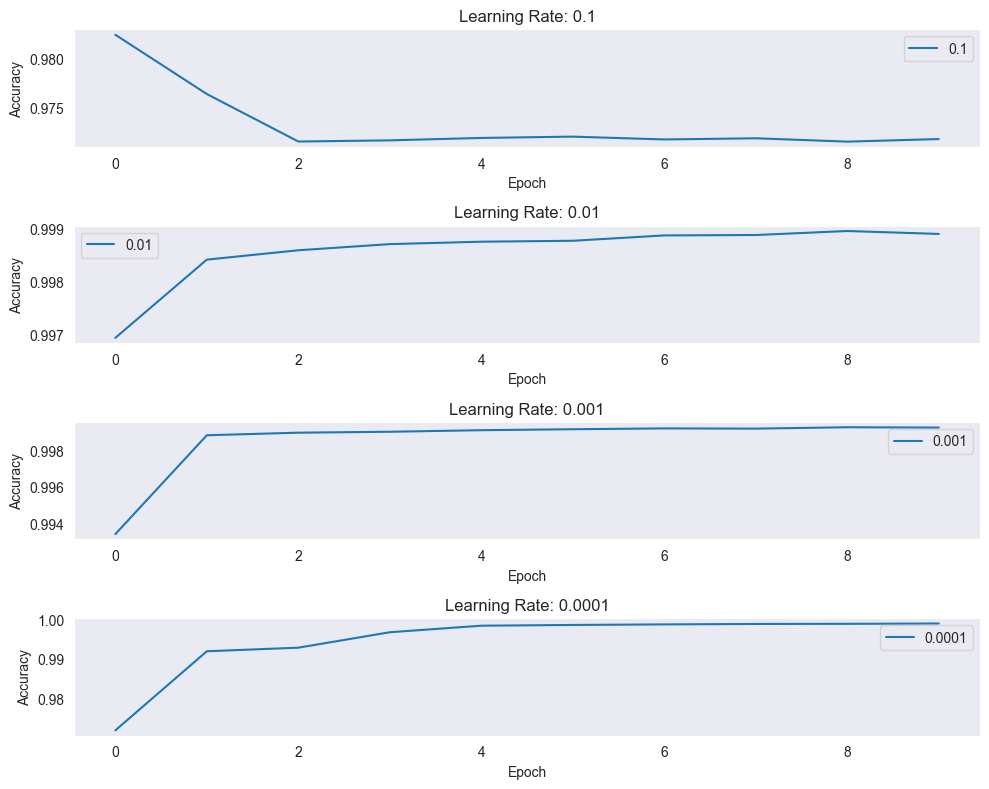

In [149]:
## checking how a model performs with different learning rates

fig, ax = plt.subplots(4,figsize=(10, 8))
ax = ax.flatten()

learning_rates = [0.1, 0.01, 0.001, 0.0001]
for i, lr in enumerate(learning_rates):
    opt = Adam(learning_rate=lr)
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    trials = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# traza las curvas de precisión en función de las épocas para cada tasa de aprendizaje, esto permite visualizar y comparar el rendimiento del modelo con diferentes tasas de aprendizaje.
    ax[i].plot(trials.history['accuracy'], label= str(lr))
    ax[i].set_title('Learning Rate: ' + str(lr))
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].legend()

plt.tight_layout()
plt.show()

learning rate 0.001

Epoch 1/10
12351/12351 [==============================] - 30s 2ms/step - loss: 0.0484 - accuracy: 0.9881 - val_loss: 0.0080 - val_accuracy: 0.9981
Epoch 2/10
12351/12351 [==============================] - 20s 2ms/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.0050 - val_accuracy: 0.9988
Epoch 3/10
12351/12351 [==============================] - 23s 2ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.0043 - val_accuracy: 0.9989
Epoch 4/10
12351/12351 [==============================] - 24s 2ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0040 - val_accuracy: 0.9990
Epoch 5/10
12351/12351 [==============================] - 26s 2ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0038 - val_accuracy: 0.9989
Epoch 6/10
12351/12351 [==============================] - 25s 2ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0037 - val_accuracy: 0.9989
Epoch 7/10
12351/12351 [==============================] - 24s 2ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0

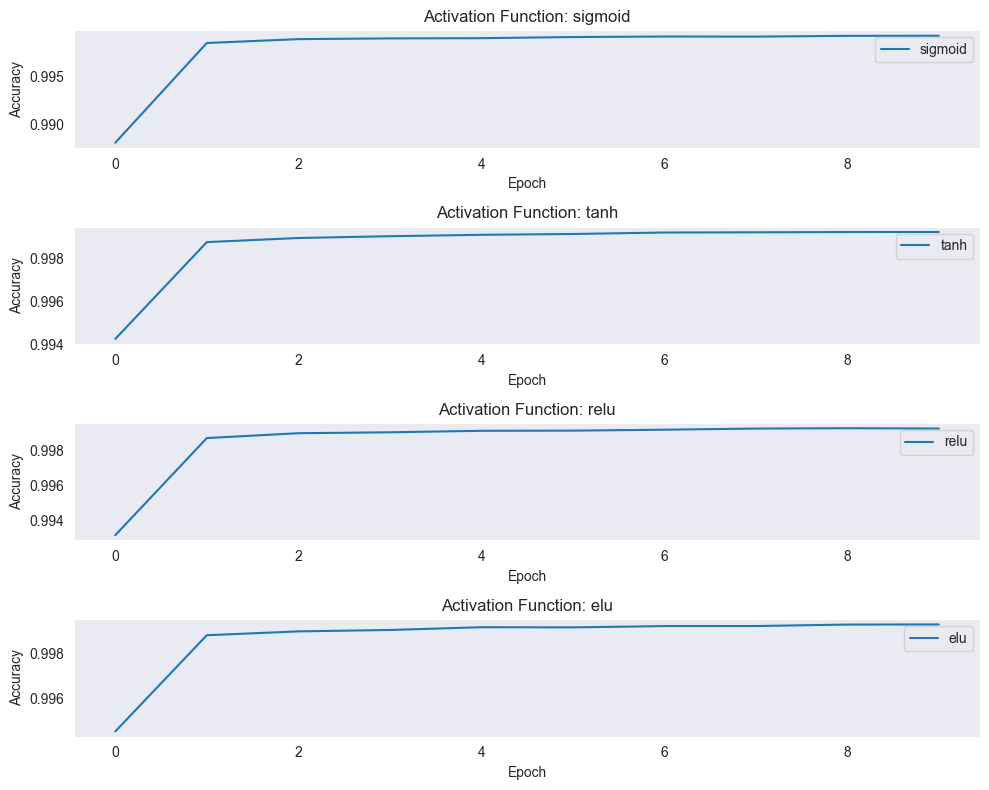

In [150]:
fig, ax = plt.subplots(4,figsize=(10, 8))
ax = ax.flatten()

#entrena y evalúa modelos con diferentes funciones de activación utilizando la optimización Adam

activation_func = ['sigmoid', 'tanh', 'relu', 'elu']
for i, acfn in enumerate(activation_func):
    opt = Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(12, activation = acfn))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    trials = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# traza las curvas de precisión en función de las épocas para cada función de activación
    ax[i].plot(trials.history['accuracy'], label= str(acfn))
    ax[i].set_title('Activation Function: ' + str(acfn))
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].legend()

plt.tight_layout()
plt.show()

## Modelling a Neural Network

In [151]:
#tamaño de entrada de la capa densa inicial del modelo
X_train.shape[1]

40

In [152]:
#modelo secuencial con dos capas ocultas de activación ReLU y una capa de salida de activación softmax. 
opt = Adam(learning_rate=0.001)
model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [153]:
#especificar la función de pérdida, el optimizador y las métricas que se utilizarán durante el entrenamiento.
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [154]:
#l entrenamiento del modelo
trials = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
4941/4941 [==============================] - 9s 2ms/step - loss: 0.0391 - accuracy: 0.9895 - val_loss: 0.0074 - val_accuracy: 0.9983
Epoch 2/10
4941/4941 [==============================] - 10s 2ms/step - loss: 0.0057 - accuracy: 0.9986 - val_loss: 0.0047 - val_accuracy: 0.9988
Epoch 3/10
4941/4941 [==============================] - 9s 2ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0044 - val_accuracy: 0.9989
Epoch 4/10
4941/4941 [==============================] - 8s 2ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0043 - val_accuracy: 0.9989
Epoch 5/10
4941/4941 [==============================] - 8s 2ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 6/10
4941/4941 [==============================] - 10s 2ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0044 - val_accuracy: 0.9990
Epoch 7/10
4941/4941 [==============================] - 10s 2ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0038 - val_accura

In [155]:
#gráfico del modelo
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


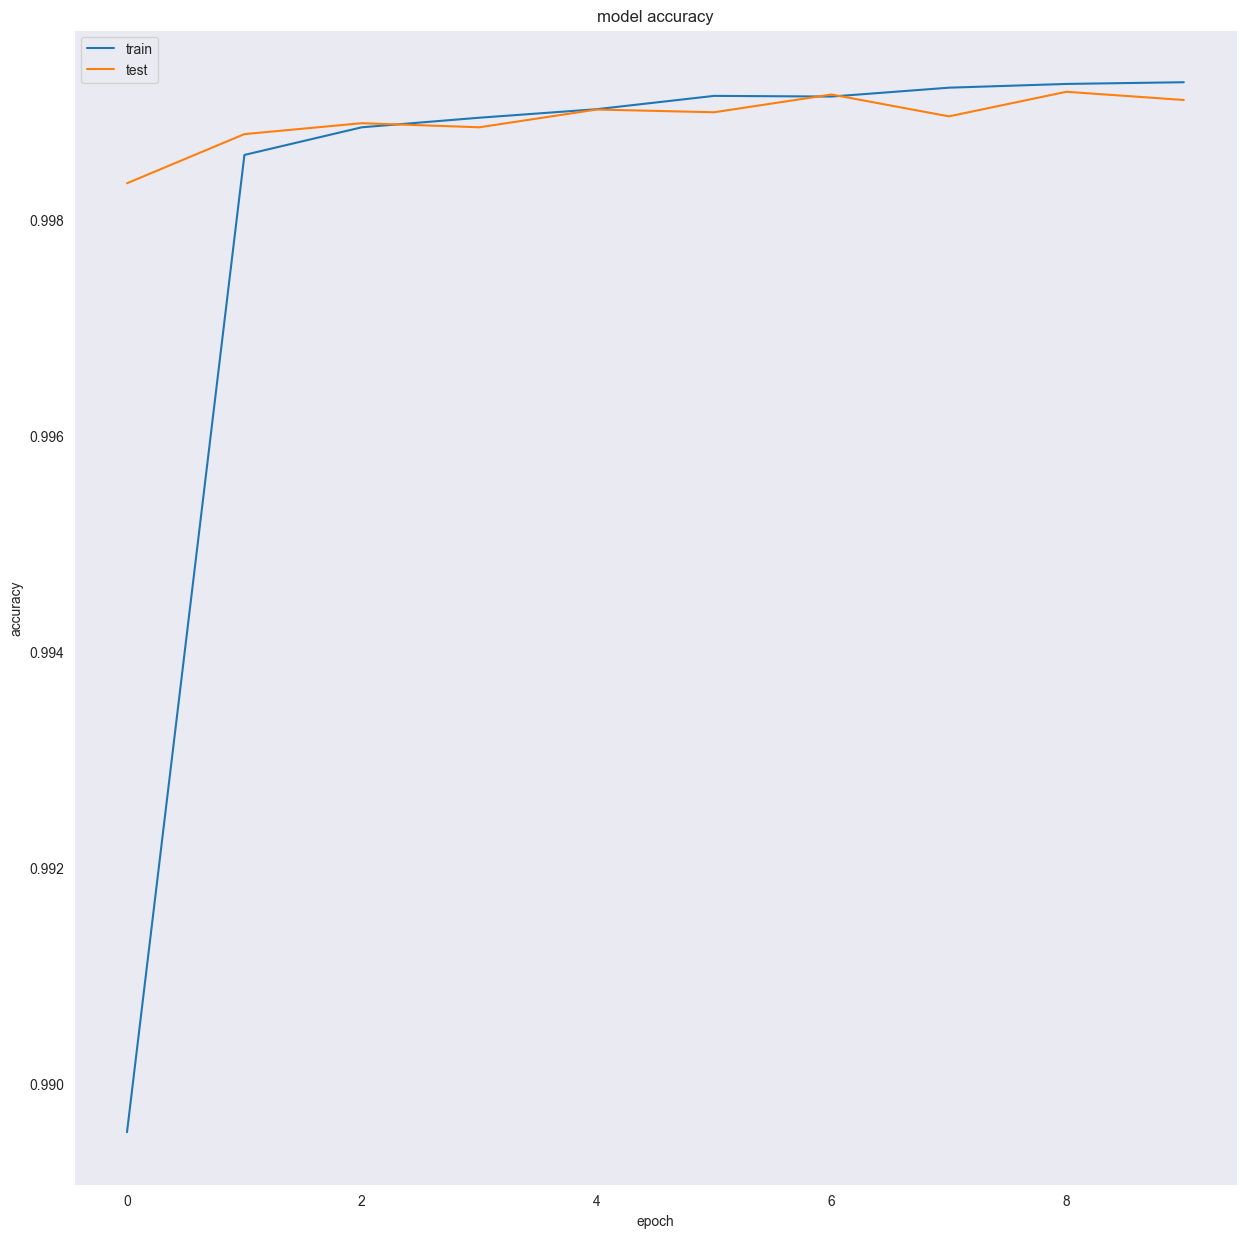

In [156]:
#precisión del modelo en el conjunto de entrenamiento y el conjunto de prueba a lo largo de las épocas.
fig, ax = plt.subplots(figsize=(15, 15))
plt.plot(trials.history['accuracy'])
plt.plot(trials.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [159]:
model.save('NN_model.h5')